# Data Exploration

In [57]:
#Importing the necessary packages
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf



from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.arima import ADFTest

In [2]:
#Impoprting the data
riv_stock_df = pd.read_csv('data/RIVN.csv', index_col = ['Date'], parse_dates=['Date'])
riv_stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500
2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200
2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800
2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300
2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600


In [3]:
#Checking the information
riv_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2021-11-10 to 2022-10-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       241 non-null    float64
 1   High       241 non-null    float64
 2   Low        241 non-null    float64
 3   Close      241 non-null    float64
 4   Adj Close  241 non-null    float64
 5   Volume     241 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.2 KB


In [4]:
#Converting date format to datetime for future plotting and calculations
riv_df = riv_stock_df.asfreq('D').ffill()

In [5]:
#Checking information
riv_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500.0
2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200.0
2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800.0
2021-11-13,128.645004,135.199997,125.250000,129.949997,129.949997,50636800.0
2021-11-14,128.645004,135.199997,125.250000,129.949997,129.949997,50636800.0


In [6]:
#Checking for any missing values
riv_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
riv_df.index[0].month

11

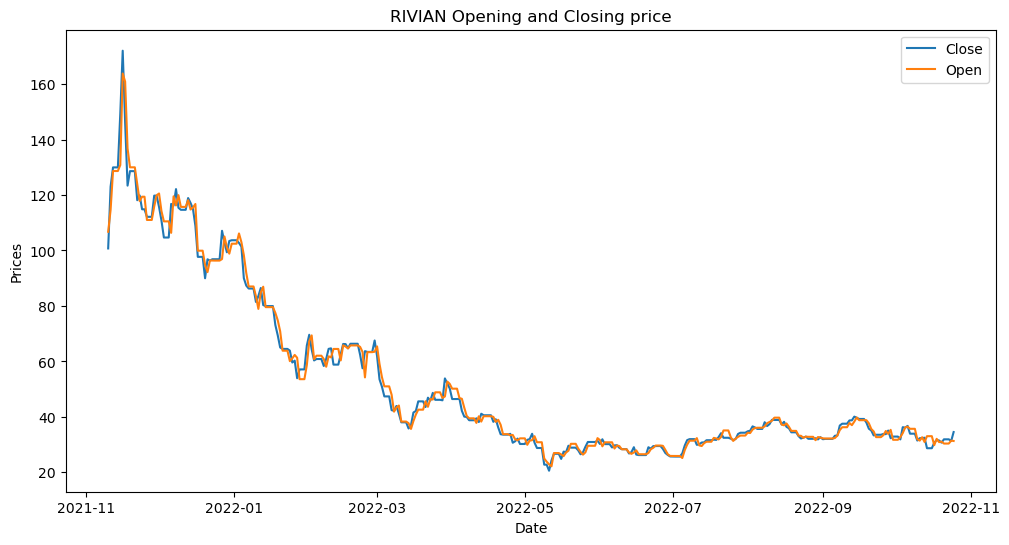

In [8]:
#Plotting the opening and closing price
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(riv_df['Close'])
plt.plot(riv_df['Open'])
plt.title('RIVIAN Opening and Closing price')
plt.legend(['Close', 'Open'])
plt.show()

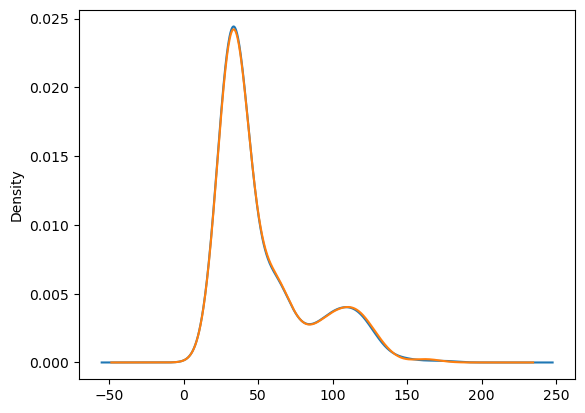

In [9]:
#Checking distribution of the dataset
riv_df_close = riv_df['Close']
riv_df_open = riv_df['Open']
riv_df_close.plot(kind='kde')
riv_df_open.plot(kind='kde');

In [10]:
#https://www.codingfinance.com/post/2018-04-03-calc-returns-py/
#Calculating daily and monthly return
riv_daily_return = pd.DataFrame(riv_df['Adj Close'].pct_change())
riv_monthly_return=pd.DataFrame(riv_df['Adj Close'].resample('M').ffill().pct_change())

In [11]:
#Chceking output
riv_daily_return

,Adj Close
Date,
2021-11-10,NaN
2021-11-11,0.220987
2021-11-12,0.056590
2021-11-13,0.000000
2021-11-14,0.000000
...,...
2022-10-21,0.038724
2022-10-22,0.000000
2022-10-23,0.000000


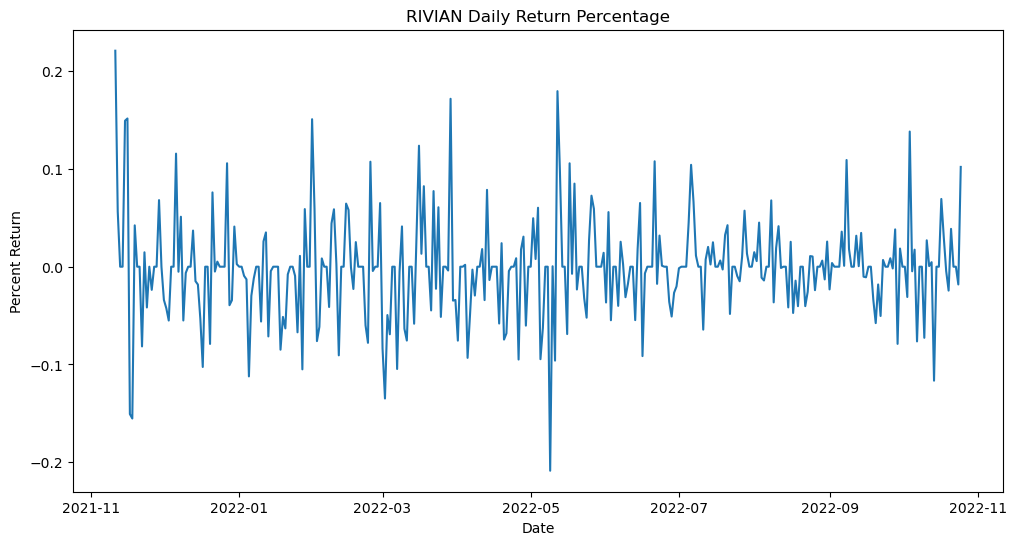

In [12]:
#Visualizing daily return
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Percent Return')
plt.plot(riv_daily_return)
plt.title('RIVIAN Daily Return Percentage')
plt.show()

In [13]:
#Checking output
riv_monthly_return

,Adj Close
Date,
2021-11-30,NaN
2021-12-31,-0.134185
2022-01-31,-0.365995
2022-02-28,0.027685
2022-03-31,-0.256365
2022-04-30,-0.398089
2022-05-31,0.038360
2022-06-30,-0.180255
2022-07-31,0.332556


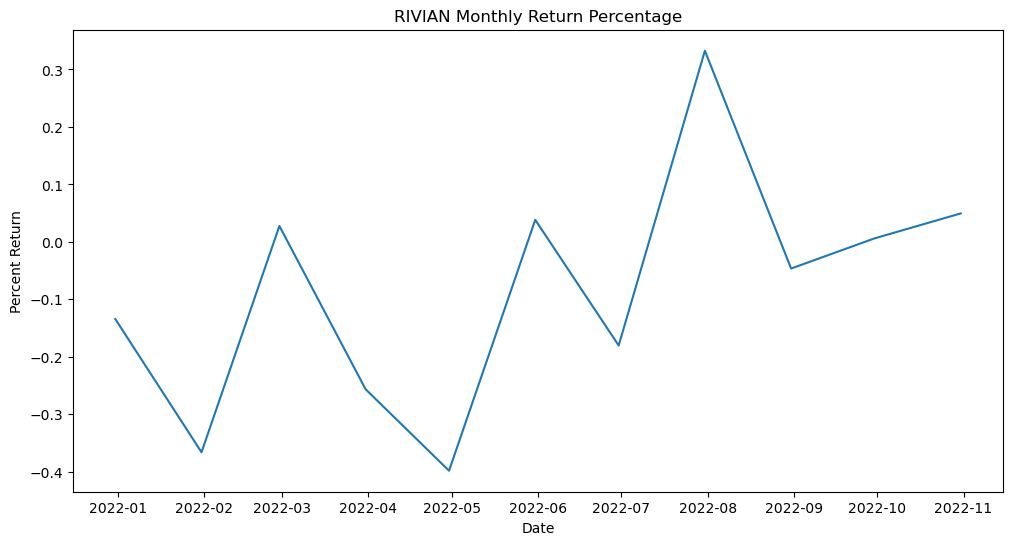

In [14]:
#Visualizing monthly return
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Percent Return')
plt.plot(riv_monthly_return)
plt.title('RIVIAN Monthly Return Percentage')
plt.show()

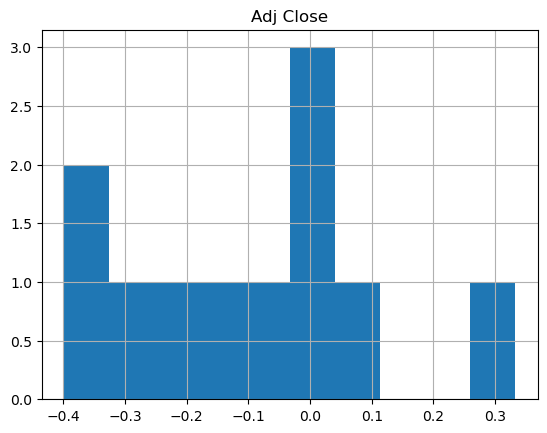

In [15]:
riv_monthly_return.hist();

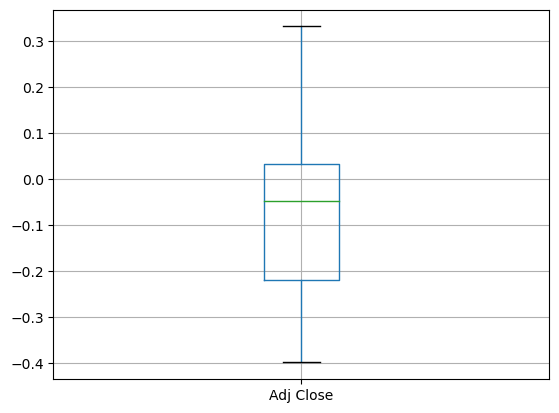

In [16]:
riv_monthly_return.boxplot();

In [17]:
# https://blog.devgenius.io/how-to-calculate-the-daily-returns-and-volatility-of-a-stock-with-python-d4e1de53e53b
#Calculating Volatility
daily_volatility_rivn = riv_daily_return['Adj Close'].std()
print('Daily volatility: \n --------------')
print('Rivian: ', '{:.2f}%'.format(daily_volatility_rivn))
print('\n')
monthly_volatility_rivn = math.sqrt(21) * daily_volatility_rivn
print('Monthly volatility: \n --------------')
print ('Rivian: ', '{:.2f}%'.format(monthly_volatility_rivn))
print('\n')
annual_volatility_rivn = math.sqrt(252) * daily_volatility_rivn
print('Annual volatility: \n --------------')
print ('Rivian: ', '{:.2f}%'.format(annual_volatility_rivn ))

Daily volatility: 
 --------------
Rivian:  0.05%


Monthly volatility: 
 --------------
Rivian:  0.23%


Annual volatility: 
 --------------
Rivian:  0.81%


# Model Preparation

In [18]:
# Creating function for assessment
def test_trend(ts_df):
    #Getting rolling statistics
    roll_mean = ts_df.rolling(11).mean()
    roll_std = ts_df.rolling(11).std()
    #Plotting rolling statistics
    fig = plt.figure(figsize=(12,7))
    plt.plot(ts_df, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print("Results of the Dickey-Fuller Test")
    dftest = adfuller(ts_df)
    # Output for dickey-fuller test will give us the values without defining what the values are.
    # Manually writing the values
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in dftest[4].items():
        dfoutput['critical value (%s)'%key] =  values
    print(dfoutput)
    print('\n\n')
    print("Results of KPSS Test:")
    kpsstest = kpss(ts_df, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

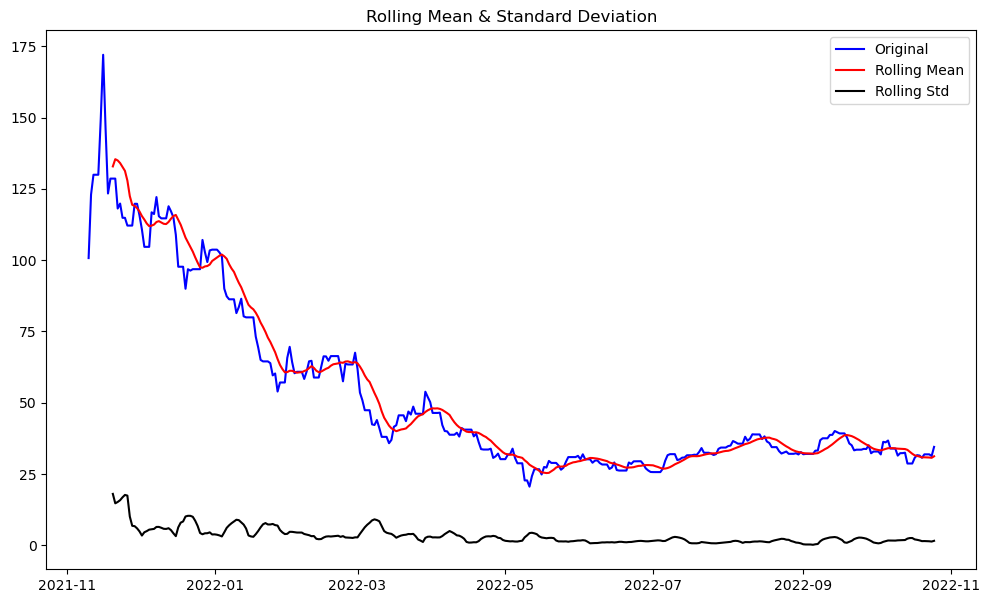

Results of the Dickey-Fuller Test
Test Statistics                 -2.963177
p-value                          0.038479
No. of lags used                15.000000
Number of observations used    334.000000
critical value (1%)             -3.450081
critical value (5%)             -2.870233
critical value (10%)            -2.571401
dtype: float64



Results of KPSS Test:
Test Statistic            2.191895
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [19]:
test_trend(riv_df['Close'])

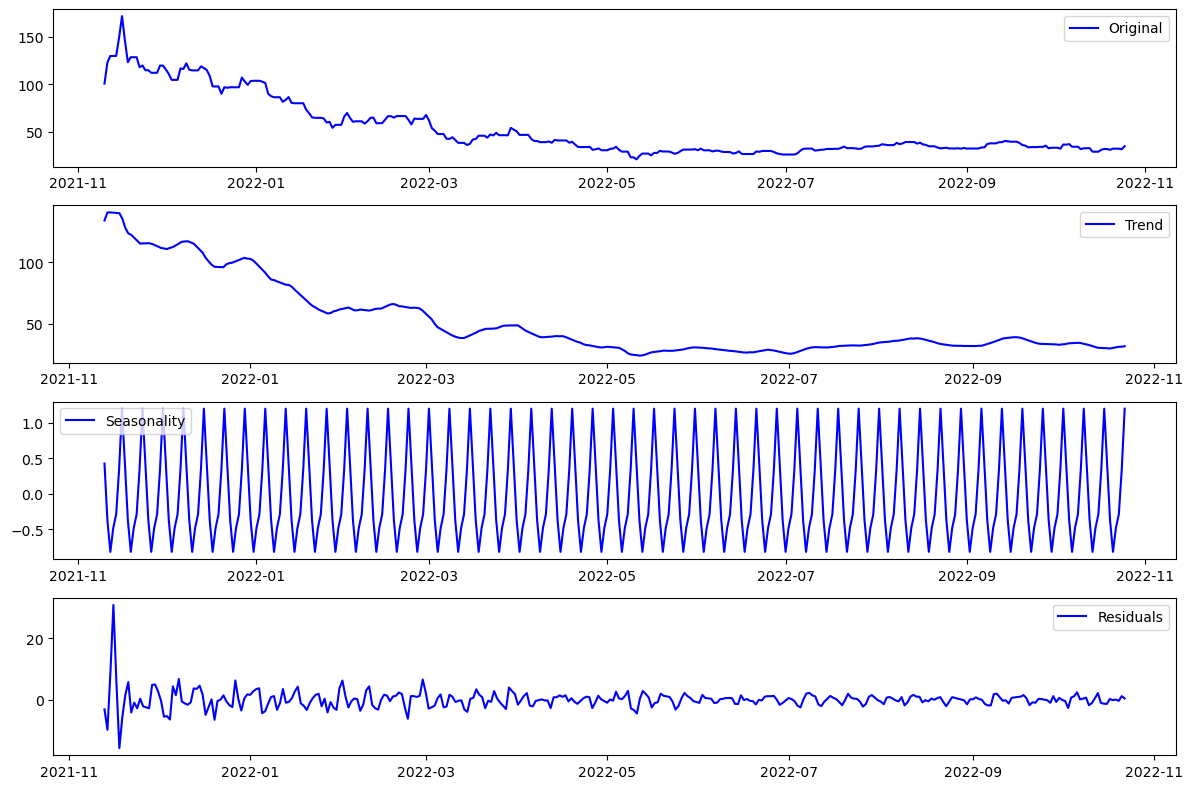

In [20]:
#Decomposing the closing data
decomposition = seasonal_decompose(riv_df['Close'].asfreq('d').ffill(), model = "additive")

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

# Plotting original, trend, seasonality, residuals
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(riv_df_close, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

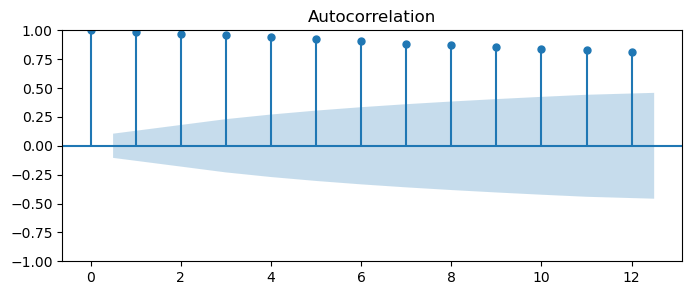

In [21]:
#Plotting the AutoCorrelation function
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(riv_df['Close'],ax=ax, lags=12);

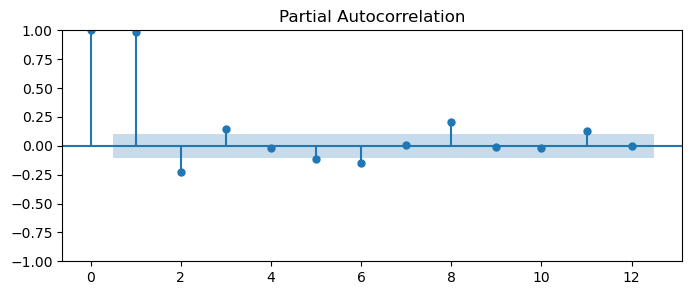

In [22]:
#Plotting the Partial AutoCorrelation Function
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(riv_df['Close'],ax=ax, lags=12, method='ywm');

## Removing the trend

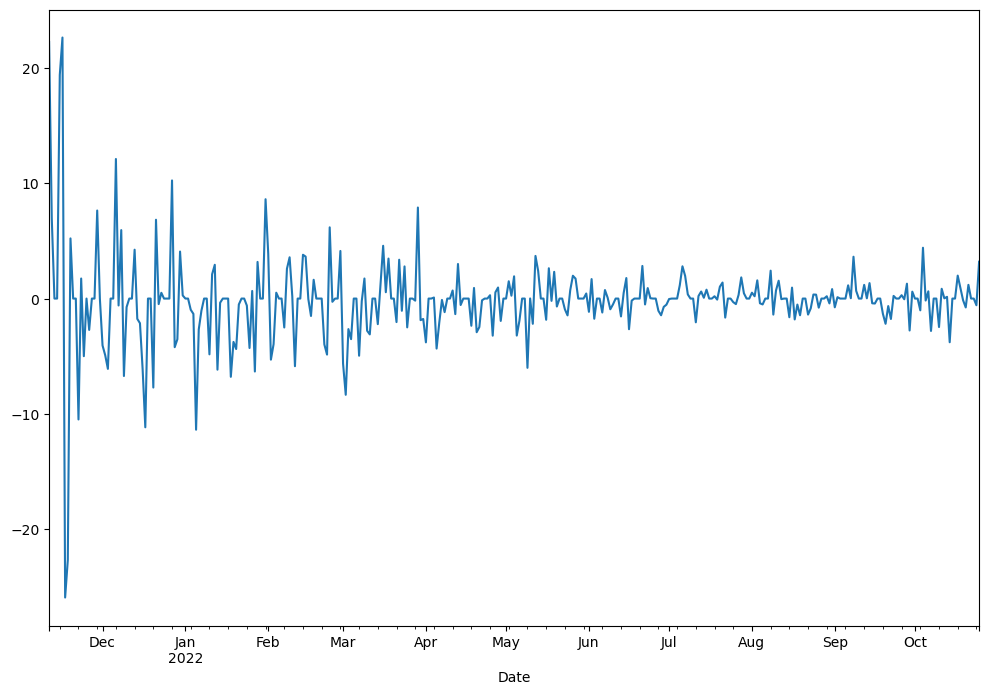

In [23]:
#Shifting the data 1 lag and subtracting it from original data
riv_df["close_diff"] = riv_df['Close'] - riv_df['Close'].shift(1)
riv_df["close_diff"].dropna().plot(figsize=(12, 8));

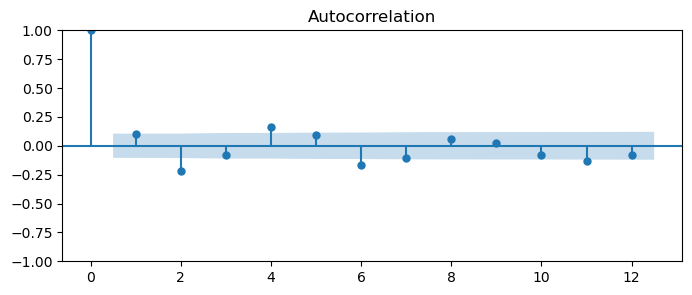

In [24]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(riv_df["close_diff"].dropna(),ax=ax, lags=12);

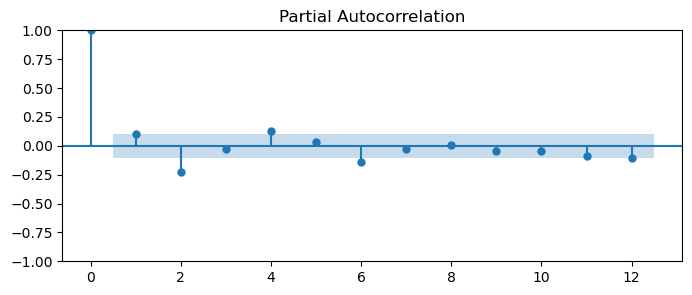

In [25]:
#Plotting the Partial AutoCorrelation Function
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(riv_df["close_diff"].dropna(),ax=ax, lags=12, method='ywm');

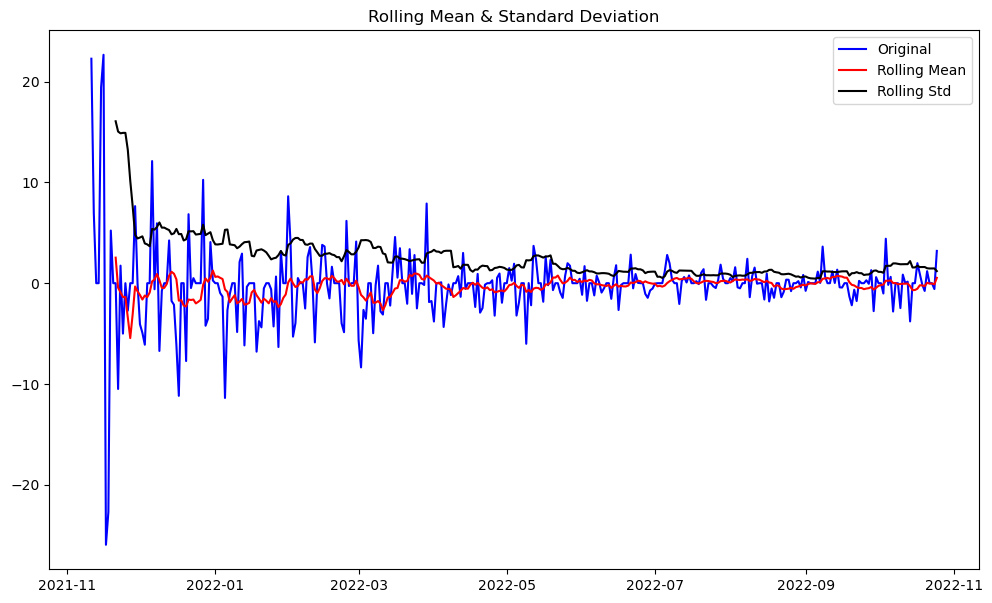

Results of the Dickey-Fuller Test
Test Statistics                 -5.271665
p-value                          0.000006
No. of lags used                17.000000
Number of observations used    331.000000
critical value (1%)             -3.450262
critical value (5%)             -2.870312
critical value (10%)            -2.571443
dtype: float64



Results of KPSS Test:
Test Statistic            0.161239
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [26]:
#Checking tests on shifted data
test_trend(riv_df['close_diff'].dropna())

In [129]:
#Splitting data into train and test
train = pd.DataFrame(riv_df['Close'].loc[:'2022-08-31'])
test = pd.DataFrame(riv_df['Close'].loc['2022-08-31':])

In [130]:
train

,Close
Date,
2021-11-10,100.730003
2021-11-11,122.989998
2021-11-12,129.949997
2021-11-13,129.949997
2021-11-14,129.949997
...,...
2022-08-27,32.110001
2022-08-28,32.110001
2022-08-29,32.310001


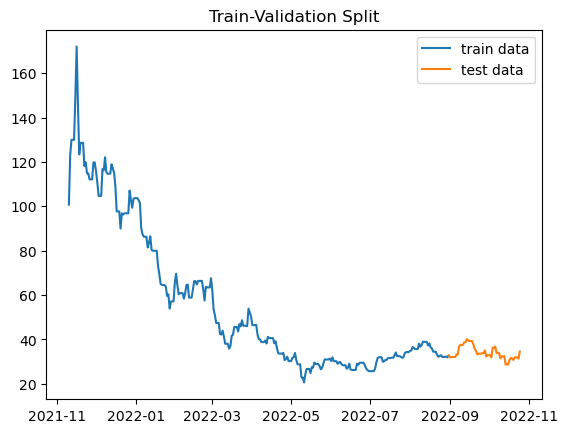

In [29]:
#Plotting train and split
fig, ax = plt.subplots()
ax.plot(train, label = 'train data')
ax.plot(test, label = 'test data')

ax.set_title("Train-Validation Split")

plt.legend();


# Modeling

## Random Walk model (I only)

In [30]:
I_model = SARIMAX(train, order=(0,1,0)).fit()
I_model.predict(typ='levels')

Date
2021-11-10      0.000000
2021-11-11    100.730003
2021-11-12    122.989998
2021-11-13    129.949997
2021-11-14    129.949997
                 ...    
2022-08-27     32.110001
2022-08-28     32.110001
2022-08-29     32.110001
2022-08-30     32.310001
2022-08-31     31.889999
Freq: D, Name: predicted_mean, Length: 295, dtype: float64

In [31]:
I_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  295
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -830.225
Date:                Mon, 07 Nov 2022   AIC                           1662.450
Time:                        14:17:47   BIC                           1666.133
Sample:                    11-10-2021   HQIC                          1663.925
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        16.6084      0.463     35.851      0.000      15.700      17.516
===================================================================================
Ljung-Box (L1) (Q):                   3.56   Jarque-Bera (JB):              2984.32
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
I_model.aic

1662.4497798765308

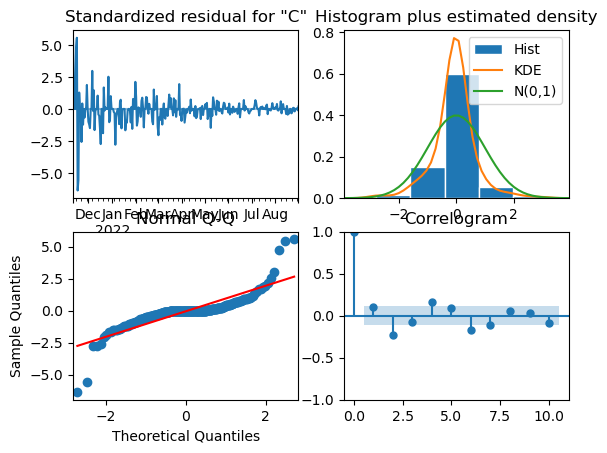

In [33]:
I_model.plot_diagnostics()
plt.show()

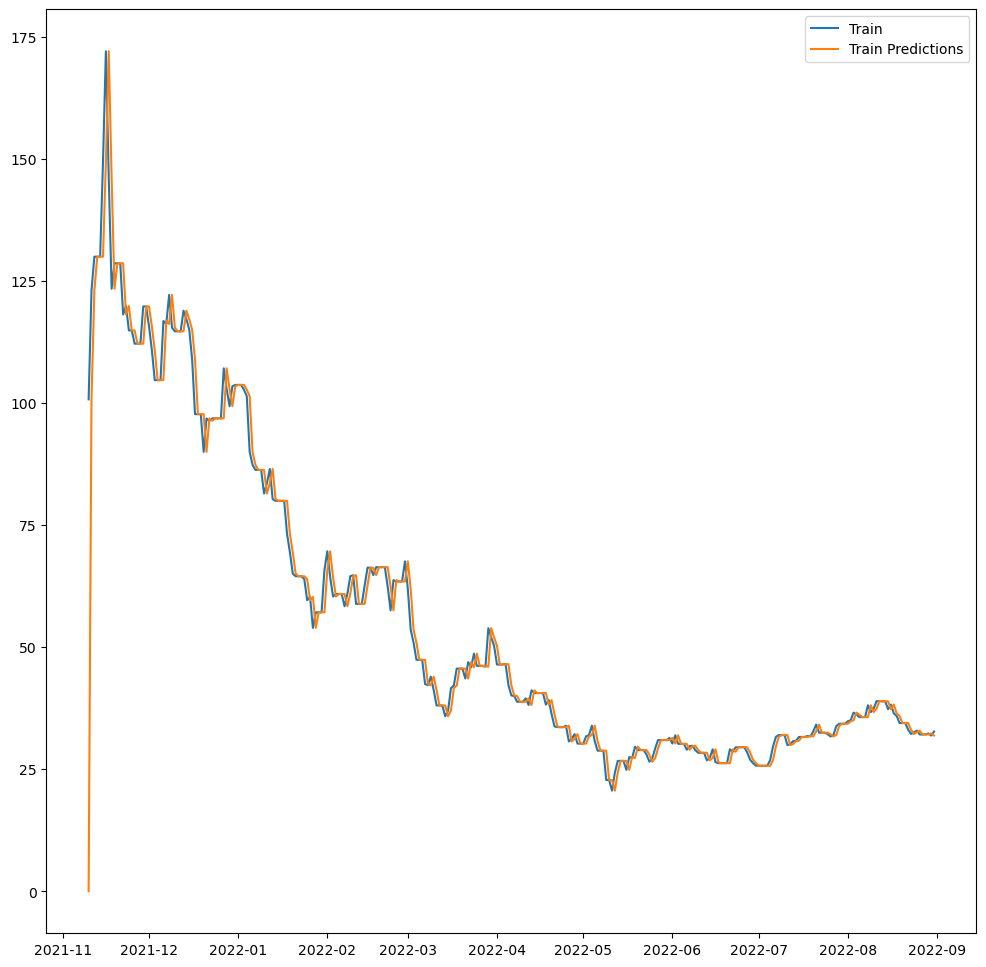

In [63]:
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(train, label = 'Train')
plt.plot(I_model.predict(typ='levels'), label = 'Train Predictions')
plt.legend(loc='best');


In [65]:
def future_df(train):
    future_dates = [train.index[-1] + DateOffset(days=x) for x in range(0,56)]
    future_dataset_df=pd.DataFrame(index = future_dates[1:], columns = train.columns)
    future_df_i = pd.concat([train, future_dataset_df])
    return future_df_i

In [66]:
future_df_i = future_df(train)
future_df_i

,Close
2021-11-10,100.730003
2021-11-11,122.989998
2021-11-12,129.949997
2021-11-13,129.949997
2021-11-14,129.949997
...,...
2022-10-21,NaN
2022-10-22,NaN
2022-10-23,NaN
2022-10-24,NaN


In [67]:
future_df_i.shape

(350, 1)

In [68]:
future_df_i.index[294]

Timestamp('2022-08-31 00:00:00')

In [83]:
future_df_i['forecast'] = I_model.predict(start = future_df_i.index[294], end = future_df_i.index[349])

In [84]:
future_df_i

,Close,forecast
2021-11-10,100.730003,NaN
2021-11-11,122.989998,NaN
2021-11-12,129.949997,NaN
2021-11-13,129.949997,NaN
2021-11-14,129.949997,NaN
...,...,...
2022-10-21,NaN,32.709999
2022-10-22,NaN,32.709999
2022-10-23,NaN,32.709999
2022-10-24,NaN,32.709999


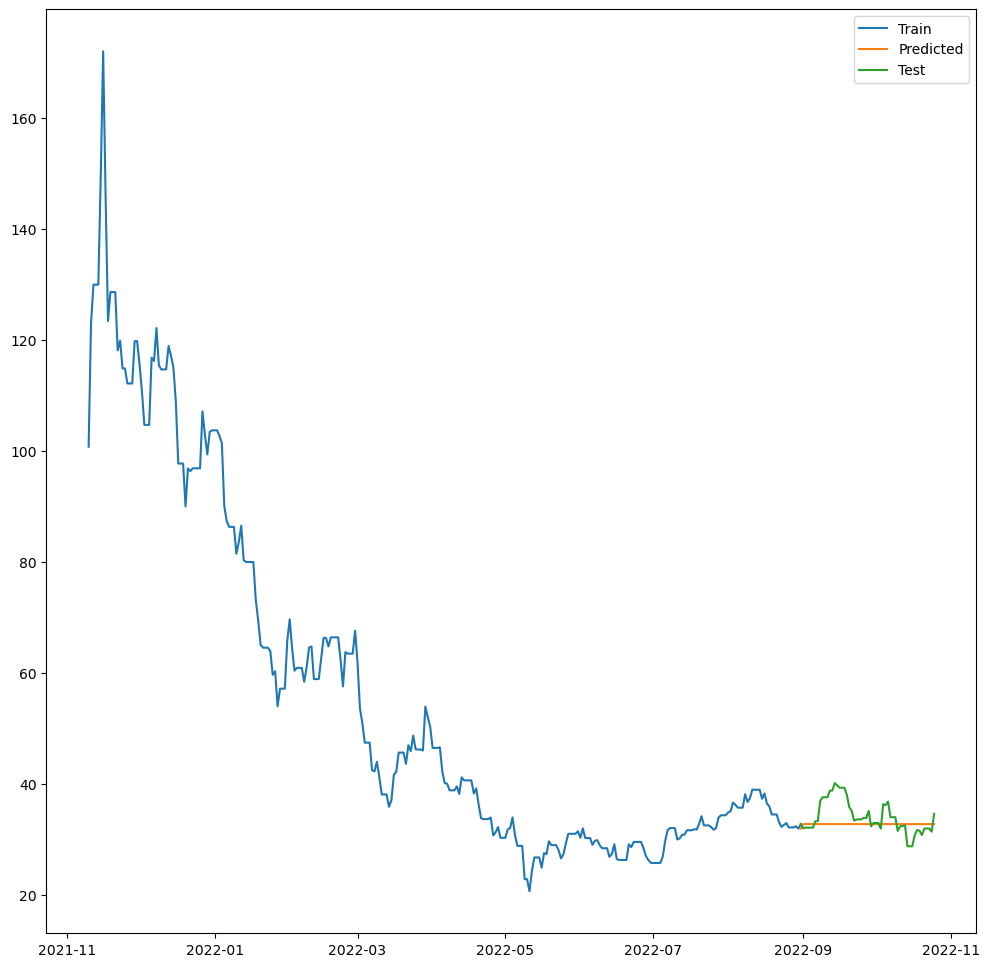

In [85]:
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(future_df_i['Close'], label = 'Train')
plt.plot(future_df_i['forecast'], label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc='best');

## ARIMA model (ARI)

In [86]:
ARI_model = SARIMAX(train, order=(1,1,0)).fit()
ARI_model.predict(typ='levels')

Date
2021-11-10      0.000000
2021-11-11    100.730214
2021-11-12    125.790844
2021-11-13    130.825733
2021-11-14    129.949997
                 ...    
2022-08-27     32.010600
2022-08-28     32.110001
2022-08-29     32.110001
2022-08-30     32.335166
2022-08-31     31.837153
Freq: D, Name: predicted_mean, Length: 295, dtype: float64

In [87]:
ARI_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  295
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -828.111
Date:                Mon, 07 Nov 2022   AIC                           1660.222
Time:                        14:36:50   BIC                           1667.589
Sample:                    11-10-2021   HQIC                          1663.173
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1258      0.017      7.229      0.000       0.092       0.160
sigma2        16.3704      0.454     36.069      0.000      15.481      17.260
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              3198.41
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

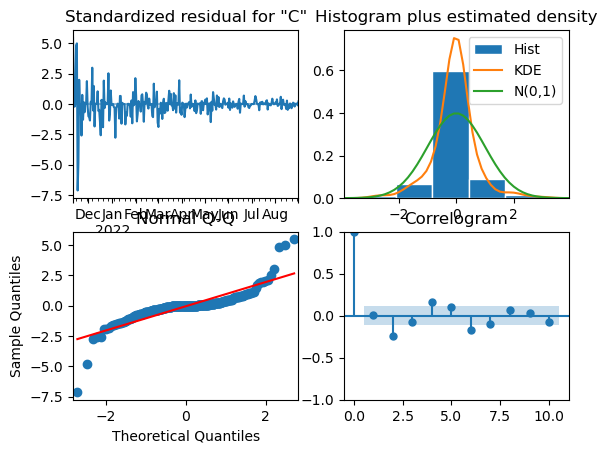

In [88]:
ARI_model.plot_diagnostics()
plt.show()

In [89]:
ARI_model.aic

1660.2222439468717

In [90]:
print("Random Walk AIC: {}".format(I_model.aic))
print("ARI AIC: {}".format(ARI_model.aic))

Random Walk AIC: 1662.4497798765308
ARI AIC: 1660.2222439468717


In [91]:
y_hat_imodel = I_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_imodel))

7.137728911063732

In [92]:
y_hat_arimodel = ARI_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_arimodel))

7.122960997539785

In [93]:
ARI_model.arparams

array([0.1258242])

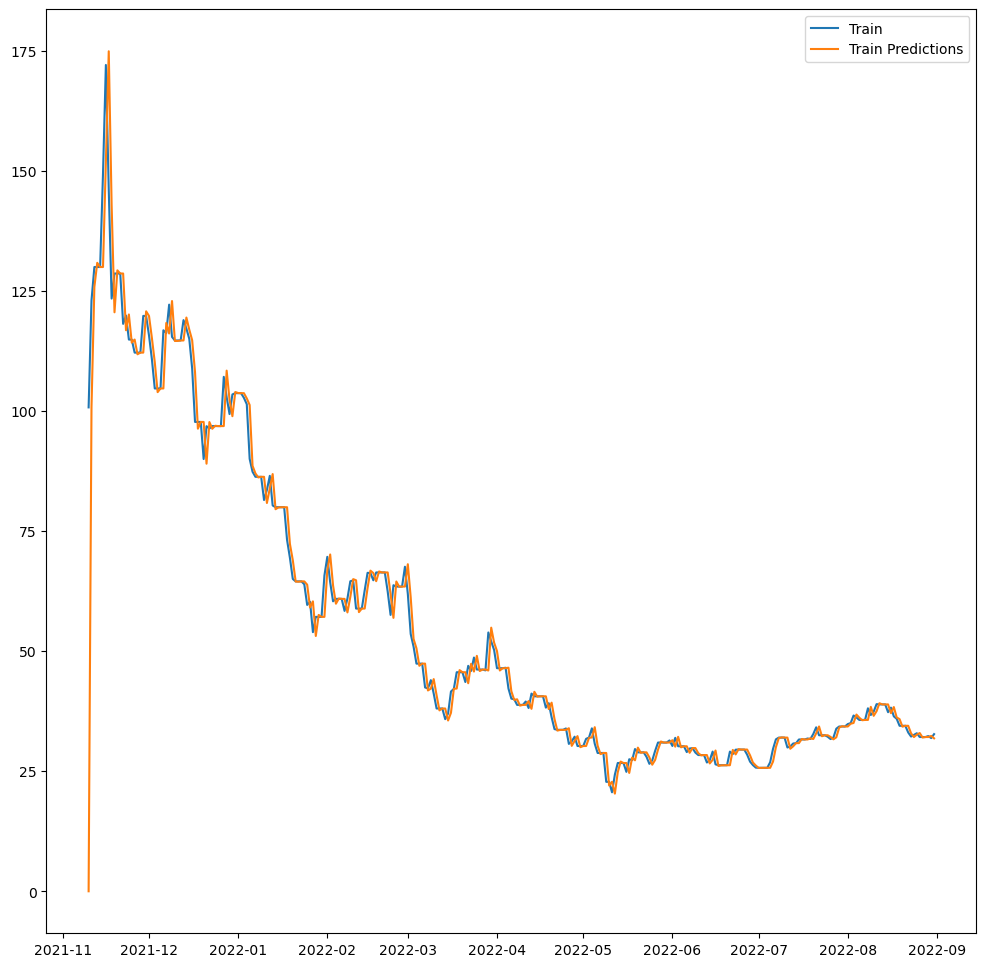

In [94]:
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(train, label = 'Train')
plt.plot(ARI_model.predict(typ='levels'), label = 'Train Predictions')
plt.legend(loc='best');

In [95]:
future_df_ari = future_df(train)
future_df_ari

,Close
2021-11-10,100.730003
2021-11-11,122.989998
2021-11-12,129.949997
2021-11-13,129.949997
2021-11-14,129.949997
...,...
2022-10-21,NaN
2022-10-22,NaN
2022-10-23,NaN
2022-10-24,NaN


In [96]:
future_df_ari['forecast'] = ARI_model.predict(start = future_df_ari.index[294], end = future_df_ari.index[349])
future_df_ari

,Close,forecast
2021-11-10,100.730003,NaN
2021-11-11,122.989998,NaN
2021-11-12,129.949997,NaN
2021-11-13,129.949997,NaN
2021-11-14,129.949997,NaN
...,...,...
2022-10-21,NaN,32.828025
2022-10-22,NaN,32.828025
2022-10-23,NaN,32.828025
2022-10-24,NaN,32.828025


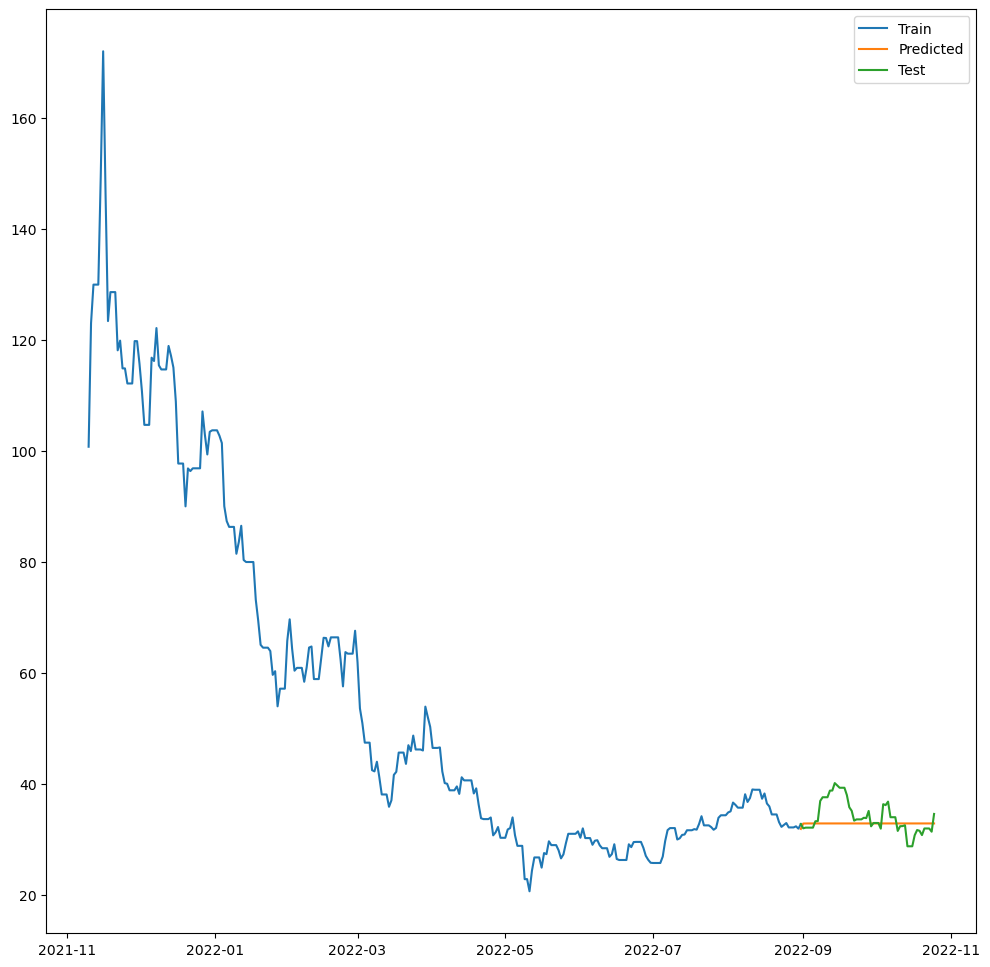

In [97]:
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(future_df_ari['Close'], label = 'Train')
plt.plot(future_df_ari['forecast'], label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc='best');

## AutoARIMA

In [100]:
auto_model_params = pm.arima.auto_arima(train, error_action = 'warn', m= 12,
                                          start_p= 0, start_d = 0, start_q = 0, 
                                          start_P = 0, start_D = 0, start_Q = 0, trace = True, 
                                          supress_warning = True, 
                                          stepwise = False, 
                                          random_state = 1)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1663.501, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1662.471, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1663.025, Time=0.17 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1661.930, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1662.502, Time=0.13 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1663.381, Time=0.24 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1663.278, Time=0.14 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1664.317, Time=0.25 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1662.399, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1658.135, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1656.885, Time=0.10 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1656.953, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1656.262, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1657.788, Time=0.17 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1658.051, Time=0.27

In [101]:
auto_model_params.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  295
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                -806.332
Date:                             Mon, 07 Nov 2022   AIC                           1626.665
Time:                                     14:38:46   BIC                           1652.450
Sample:                                 11-10-2021   HQIC                          1636.991
                                      - 08-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5864      0.470     -1.248      0.212      -1.507       0.334
ar.L1          0.0948      0.021      4.522      0.000       0.054       0.136
ar.L2         -0.9568      0.013    -71.999      0.000      -0.983      -0.931
ma.L1          0.0088      0.034      0.262      0.794      -0.057       0.074
ma.L2          0.7881      0.047     16.891      0.000       0.697       0.880
ar.S.L12      -0.2052      0.059     -3.492      0.000      -0.320      -0.090
sigma2        14.0332      0.661     21.223      0.000      12.737      15.329
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               676.57
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARI based on autoarima

In [131]:
auto_ARI_model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,0,0,12)).fit()
auto_ARI_model

In [132]:
print("Random Walk AIC: {}".format(I_model.aic))
print("ARI AIC: {}".format(ARI_model.aic))
print("Auto-ARI AIC: {}".format(auto_ARI_model.aic))

Random Walk AIC: 1662.4497798765308
ARI AIC: 1660.2222439468717
Auto-ARI AIC: 1626.8196083281935


C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


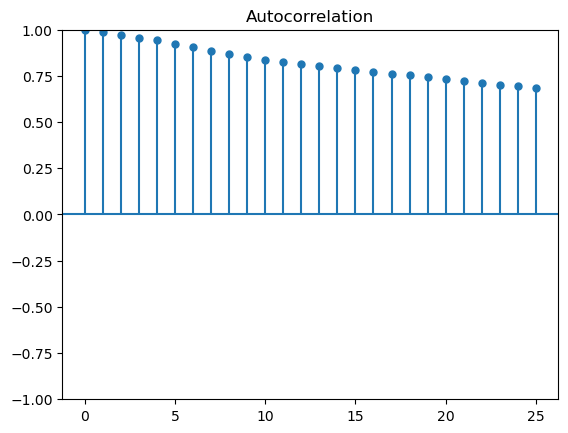

In [133]:
pm.plot_acf(train)

In [134]:
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(train)
print(p_val, should_diff)

0.07966338590739408 True


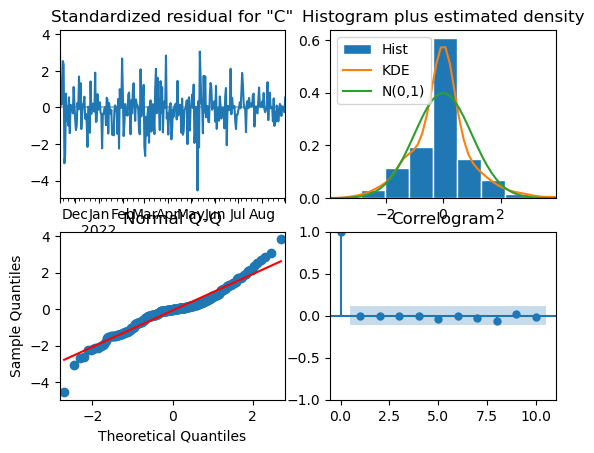

In [127]:
auto_ARI_model.plot_diagnostics()
plt.show()

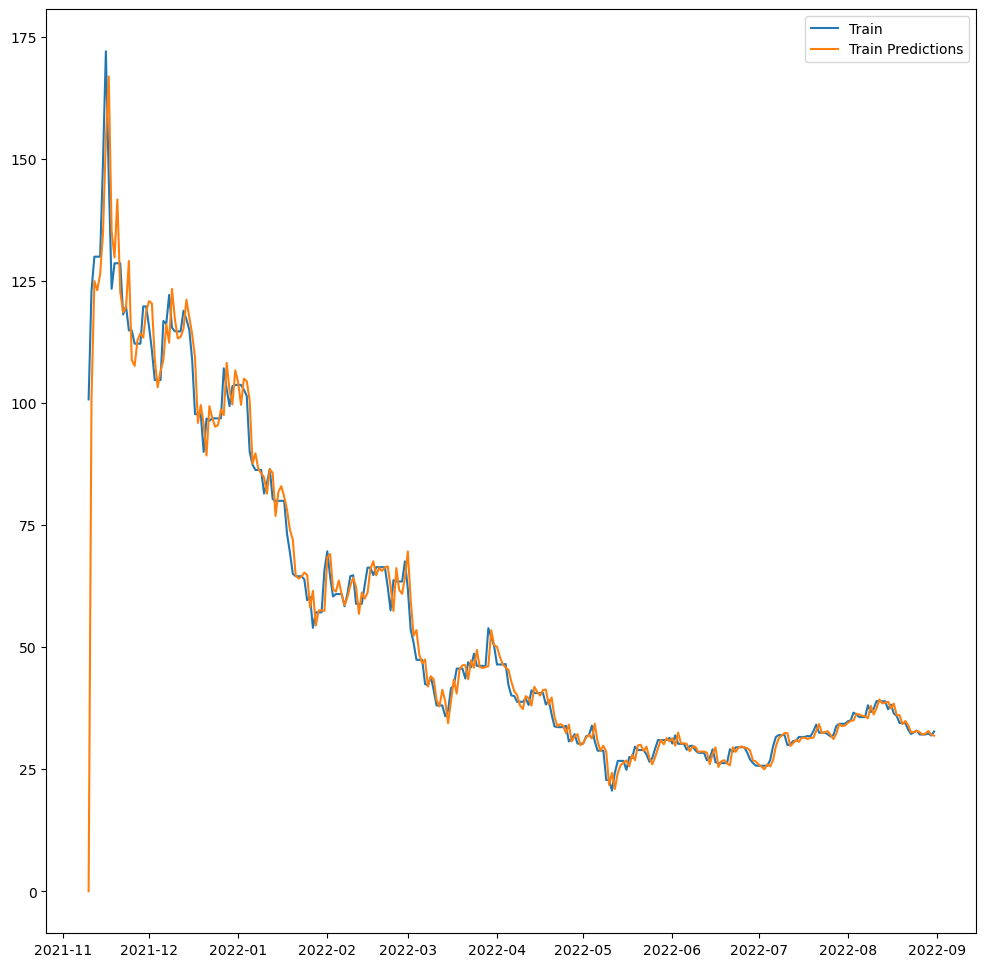

In [135]:
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(train, label = 'Train')
plt.plot(auto_ARI_model.predict(typ='levels'), label = 'Train Predictions')
plt.legend(loc='best');

In [136]:
future_df_auto_ari = future_df(train)
future_df_auto_ari

,Close
2021-11-10,100.730003
2021-11-11,122.989998
2021-11-12,129.949997
2021-11-13,129.949997
2021-11-14,129.949997
...,...
2022-10-21,NaN
2022-10-22,NaN
2022-10-23,NaN
2022-10-24,NaN


In [137]:
future_df_auto_ari['forecast'] = auto_ARI_model.predict(start = future_df_auto_ari.index[294], end = future_df_auto_ari.index[349])
future_df_auto_ari

,Close,forecast
2021-11-10,100.730003,NaN
2021-11-11,122.989998,NaN
2021-11-12,129.949997,NaN
2021-11-13,129.949997,NaN
2021-11-14,129.949997,NaN
...,...,...
2022-10-21,NaN,33.315019
2022-10-22,NaN,33.296191
2022-10-23,NaN,33.183873
2022-10-24,NaN,33.191413


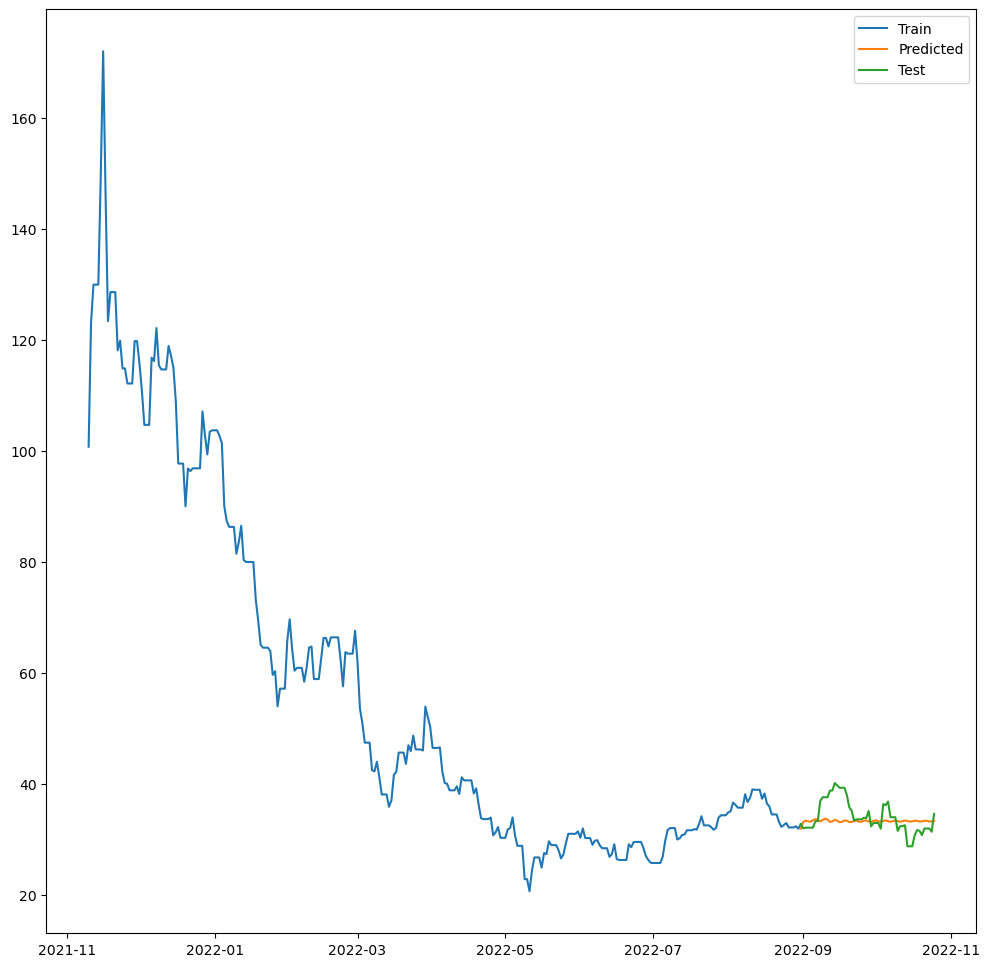

In [138]:
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(future_df_auto_ari['Close'], label = 'Train')
plt.plot(future_df_auto_ari['forecast'], label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc='best');